## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from sklearn import datasets

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [4]:
import warnings
warnings.filterwarnings('ignore')

## **Datos**

In [5]:
iris = datasets.load_iris()

In [6]:
df_features = pd.DataFrame(iris['data'])
df_features.columns = list(iris['feature_names'])

In [7]:
df_target = pd.DataFrame(iris['target'])
df_target.columns = ['species']

In [8]:
df_iris = pd.merge(
    df_target.reset_index(),
    df_features.reset_index()
)

df_iris.drop('index', axis=1, inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, 
    df_target, 
    random_state=13, 
    test_size=0.1
)

## **Modelo**

In [10]:
model = RandomForestClassifier(random_state=13)

In [24]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=13)

In [11]:
accuracy = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)

In [12]:
print(f'La precisión promedio del modelo es de {round(accuracy.mean() * 100, 2)}%')

La precisión promedio del modelo es de 97.09%


In [13]:
y_pred = model.predict(X_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

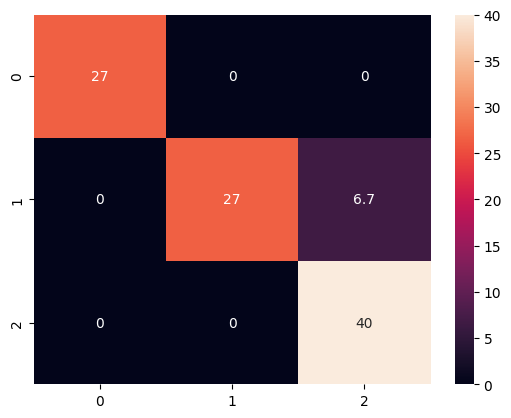

In [28]:
sns.heatmap(confusion_matrix(y_pred, y_test)/len(y_pred)*100, annot=True)

plt.show()

In [31]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.80      0.89         5
           2       0.86      1.00      0.92         6

    accuracy                           0.93        15
   macro avg       0.95      0.93      0.94        15
weighted avg       0.94      0.93      0.93        15



## **Librerías**

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [130]:
from matplotlib.patches import Patch

In [131]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [73]:
import lightgbm as lgbm

In [118]:
from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit, 
    KFold, 
    StratifiedKFold, 
    GroupKFold, 
    StratifiedGroupKFold
) 

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix
)


In [144]:
import utils.functions as utils

## **Datos**

In [8]:
df = pd.read_csv('./Datos/healthcare-dataset-stroke-data.csv')

In [10]:
df.sample()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1550,25935,Female,50.0,0,0,No,Self-employed,Urban,77.67,34.5,Unknown,0


### **Limpieza de datos**

In [17]:
# Volvemos booleana la variable ever_married
df['ever_married'].replace({
    'Yes': True,
    'No': False
    }, inplace=True) 

In [24]:
# Ajustamos el formato de nuestras variables categoricas
df['gender'] = df['gender'].astype('category')
df['smoking_status'] = df['smoking_status'].astype('category')
df['Residence_type'] = df['Residence_type'].astype('category')
df['work_type'] = df['work_type'].astype('category')

In [25]:
# Creamos una variable aleatoria doctor
df['doctor'] = np.random.randint(0, 8, size=len(df))

In [34]:
# Escogemos aleatoriamente 500 ids que quedaran fuera de nuestro dataset de entrenamiento
holdout_ids = df.sample(n=500, random_state=529).index

In [52]:
# Preparamos nuestra dataset de entrenamiento
df_train = df.loc[
        ~df.index.isin(holdout_ids)
    ].sample(
        frac=1, 
        random_state=529
        ).sort_values(
            'doctor'
            ).reset_index(
                drop=True
                )

In [54]:
# Preparamos nuestro dataset de validación
df_holdout = df.loc[
        df.index.isin(holdout_ids)
    ].sample(
        frac=1, 
        random_state=529
        ).sort_values(
            'doctor'
            ).reset_index(
                drop=True
                )

### **Datos para el modelo**

In [95]:
features = [
    'gender',
    'age',
    'hypertension', 
    'heart_disease', 
    'ever_married',
    'work_type', 
    'Residence_type', 
    'avg_glucose_level', 
    'bmi',
    'smoking_status', 
]

group = 'doctor'
target = 'stroke'

In [96]:
X = df_train[features]
y = df_train[target]
groups = df_train[group]

## **Modelo**

In [97]:
clf = lgbm.LGBMClassifier(n_estimators=100)

In [98]:
clf.fit(X, y)

[LightGBM] [Info] Number of positive: 223, number of negative: 4387
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4610, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048373 -> initscore=-2.979229
[LightGBM] [Info] Start training from score -2.979229


LGBMClassifier()

In [99]:
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)[:, 1]

In [100]:
y_pred_proba

array([3.16678711e-02, 9.72631927e-04, 2.22963744e-05, ...,
       1.08076843e-02, 4.91105774e-03, 1.85916815e-01])

In [101]:
acc_score = accuracy_score(y, y_pred)
acc_score

0.9911062906724512

In [102]:
roc_score = roc_auc_score(y, y_pred_proba)
roc_score

0.9997403662063107

### **Validación**

In [103]:
X_val = df_holdout[features]
y_val = df_holdout[target]
groups_val = df_holdout[group]

In [107]:
y_pred_val = clf.predict(X_val)
y_pred_proba_val = clf.predict_proba(X_val)[:, 1]

In [110]:
acc_score = accuracy_score(y_val, y_pred_val)
acc_score

0.938

In [112]:
roc_score = roc_auc_score(y_val, y_pred_proba_val)
roc_score

0.7801850048685491

In [116]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       474
           1       0.00      0.00      0.00        26

    accuracy                           0.94       500
   macro avg       0.47      0.49      0.48       500
weighted avg       0.90      0.94      0.92       500



### **Train_test_split**

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.1)

In [123]:
clf = lgbm.LGBMClassifier(n_estimators=100)

In [124]:
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 201, number of negative: 3948
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048445 -> initscore=-2.977659
[LightGBM] [Info] Start training from score -2.977659


LGBMClassifier()

In [125]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [126]:
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.9522776572668112

In [128]:
roc_score = roc_auc_score(y_test, y_pred_proba)
roc_score

0.8143507972665149

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       439
           1       0.50      0.18      0.27        22

    accuracy                           0.95       461
   macro avg       0.73      0.59      0.62       461
weighted avg       0.94      0.95      0.94       461



### **Cross Validation**

In [147]:
X_, y_, groups_ = utils.get_fake_X_y()

NameError: name 'np' is not defined